<a href="https://colab.research.google.com/github/Ed-Cheng/Potential-Stock-Finder/blob/main/twStock_Analysis_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and initialize functions



In [8]:
pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from datetime import datetime, date, timedelta
import io
import math
import matplotlib.pyplot as plt
import matplotlib.image  as m_img
import numpy as np
import pandas as pd
from pandas_datareader import data
from tqdm import tqdm

import mplfinance as fplt
import yfinance as yf

In [10]:
def get_tw_stock(target_stock: str, start_date: datetime, end_date: datetime) -> pd.DataFrame:
  """ Read the stock data, moded for tw tickers"""
  # "try" is used to deal with yfinance glitch when looping (hope this is fixed soon)
  try:
    yf.pdr_override()
    ticker = f"{target_stock}.TW"
    df = data.get_data_yahoo([ticker], start_date, end_date, progress=False, show_errors=False)
    # fill in missing values, if any
    df = df.interpolate()
    if not df.empty:
      return df

    ticker = f"{target_stock}.TWO"
    df = data.get_data_yahoo([ticker], start_date, end_date, progress=False, show_errors=False)
    # fill in missing values, if any
    df = df.interpolate()
    return df

  except:
    print(f"{target_stock} encounter bugs")
    return pd.DataFrame()


def load_tw_data(symbol_list: list, ago: datetime, tdy: datetime) -> dict:
  """ get all the stock info in the given list """
  # Store stock details for plotting
  detail_dict = {}
  bug_count = 0

  for i, firm in enumerate(tqdm(symbol_list)):
    # only care about stocks, not etfs, so len must = 4
    if bug_count > 20:
      print("session terminated, too many bugs")
      break
    if len(firm) == 4:
      stock = get_tw_stock(firm, ago, tdy)
      # if data less than half of the period, issue will be raised
      if len(stock) < (tdy - ago).days/2:
        print(f"'{firm}' skipped due to insufficient data")
        bug_count += 1
      else:
        add_indicator(stock)
        detail_dict[firm] = stock.copy()

  return detail_dict


def get_slope(stock_df: pd.DataFrame, day=5) -> list:
  """
  Calculates the linear regression slope over a period of days
  Note that a 10% growth over 5 days gives a slope of (1.1-1)/5=0.02
  """
  slope = [np.NaN] * (day - 1)
  x = np.vstack([np.arange(day), np.ones(day)]).T
  y = stock_df["Close"].to_numpy()

  for i in np.arange(len(stock_df) - (day - 1)):
    # Very important to normalize
    Y = y[i:i+day]/y[i]
    s, _ = np.linalg.lstsq(x, Y, rcond=None)[0]
    slope.append(s)

  return slope


def add_indicator(stock_df: pd.DataFrame) -> None:
  """
  Add indicators to the stock info dataframe
  Includes various info of:
    Price change
    Moving Average
    Volume Moving Average
    Slope
    Bollinger Bands
  """

  stock_df["InDayChg"] = 100*(stock_df["Close"] - stock_df["Open"])/stock_df["Open"]
  stock_df["PriceChg"] = 100*(stock_df["Close"] - stock_df.shift(1)["Close"])/stock_df.shift(1)["Close"]

  indicator_days = [3, 5, 10, 20]
  for days in indicator_days:
    # Price Moving Average (MA)
    stock_df[f"MA{days}"] = stock_df["Close"].rolling(days).mean()

    # Volume Moving Average (VMA)
    stock_df[f"VMA{days}"] = stock_df["Volume"].rolling(days).mean()

    # Volume Moving Average (VMA) relative to today's volume
    stock_df[f"relVMA{days}"] = stock_df["Volume"]/stock_df[f"VMA{days}"]

  stock_df["slope"] = get_slope(stock_df, 5)

  # bollinger-band
  stock_df["STD"] = stock_df["Close"].rolling(20).std()
  stock_df["STD+2"] = stock_df["MA20"] + 2*stock_df["STD"]
  stock_df["STD-2"] = stock_df["MA20"] - 2*stock_df["STD"]


def add_ranking(candidate: list, ranking: dict, screen_name: str) -> dict:
  """
  Store the result of each ticker after one analysis
  """
  for c in candidate:
    if c in ranking:
      ranking[c].append(screen_name)
    else:
      ranking[c] = [screen_name]
  return ranking


def candle_plot(stock_df: pd.DataFrame, title: str) -> None:
  """
  Plot a candle plot for one ticker
  """
  # This adds a side plot, decide where the plot goes by "panel"
  VMA5 = fplt.make_addplot(stock_df["VMA5"], color="red", width=1.5, panel=1)
  VMA10 = fplt.make_addplot(stock_df["VMA10"], color="orange", width=1.5, panel=1)
  VMA20 = fplt.make_addplot(stock_df["VMA20"], color="purple", width=1.5, panel=1)

  fplt.plot(stock_df,
            type='candle',
            addplot = [VMA5, VMA10, VMA20],
            # style='charles',
            mav=(5, 10, 20),
            mavcolors=["red", "orange", "purple"],
            xlim=(len(stock_df)-40, len(stock_df)),
            # title=title,
            ylabel=f"Price of {title}",
            volume=True,
            ylabel_lower='Volume')


# https://github.com/matplotlib/mplfinance/issues/318
def candle_plot_multi(stock_df: pd.DataFrame, title: str) -> None:
  """
  Plot two plots in one figure, one candle plot and one slope plot
  """
  sav1 = io.BytesIO()
  sav2 = io.BytesIO()

  # This adds a side plot, decide where the plot goes by "panel"
  VMA5 = fplt.make_addplot(stock_df["VMA5"], color="red", width=1.5, panel=1)
  VMA10 = fplt.make_addplot(stock_df["VMA10"], color="orange", width=1.5, panel=1)
  VMA20 = fplt.make_addplot(stock_df["VMA20"], color="purple", width=1.5, panel=1)
  upper = fplt.make_addplot(stock_df["STD+2"], color="grey", width=1, panel=0)
  lower = fplt.make_addplot(stock_df["STD-2"], color="grey", width=1, panel=0)

  # Plot 1: candle plot
  fplt.plot(stock_df,
            type='candle',
            addplot = [upper, lower, VMA5, VMA10, VMA20],
            # style='charles',
            mav=(5, 10, 20),
            mavcolors=["red", "orange", "purple"],
            xlim=(len(stock_df)-40, len(stock_df)),
            # title=title,
            ylabel=f"Price of {title}",
            volume=True,
            ylabel_lower='Volume',
            savefig=sav1)

  # Plot 2: slope plot
  fig, ax = plt.subplots(figsize=(4,2))
  ax.bar(np.arange(-14, 1), stock_df['slope'][-15:])
  ax.set_title('Price-trend momentum')
  ax.set_ylabel('Slope')
  ax.set_xlabel('Past x days')
  ax.set_yticks(np.arange(-0.02, 0.1, 0.02))
  plt.savefig(sav2, bbox_inches='tight')
  plt.close()

  # Rewind the files:
  _ = sav1.seek(0)
  _ = sav2.seek(0)

  # Read the files as images:
  img1 = m_img.imread(sav1)
  img2 = m_img.imread(sav2)

  # Create side-by-side Axes:
  fig = plt.figure(figsize=(12, 6))
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)

  # Turn the axis lines and labels off since the images will already contain them
  ax1.set_axis_off()
  ax2.set_axis_off()

  # Plot each image on a separate axes:
  ax1.imshow(img1)
  ax2.imshow(img2)
  plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.0, hspace=0)
  plt.show()


def display_analysis(tickers: list, target_dict: dict, info_dict: dict) -> None:
  """ Iterate through all the tickers and display the candel plot and slope plot"""
  for t in tickers:
    print(f"{t}, {info_dict[t]}")
    candle_plot_multi(target_dict[t], t)


## Webscrape the ticker list (Index, Russell, S&P500...)


In [11]:
tw_df = pd.read_html("https://histock.tw/stock/rank.aspx?m=13&d=1&p=all")[0]
tw_df = tw_df.applymap(str)
detail_dict = {key: [val, idx] for key, val, idx in zip(tw_df["代號▼"], tw_df["名稱▼"], tw_df.index)}

## Load personal ticker list from google drive (If applicable)
Comment this section out if don't have a personal list

In [12]:
# Personal tickers
excel_path = "/content/drive/MyDrive/Colab Notebooks/2023-03 Trading/tw_stock.xlsx"
my_df = pd.read_excel(excel_path)
my_df = my_df.applymap(str)
my_df['updated'] = pd.to_datetime(my_df['updated'])



In [14]:
# Add personal notes to the detail dict
for i in range(len(my_df)):
  temp = my_df.loc[i]
  detail_dict[temp.ticker].append(temp.level)
  detail_dict[temp.ticker].append(temp.news)


## Check the date for analysis
Check if market is open; the time zone may be different, etc

In [15]:
tdy = datetime.now()
# Include a day more to deal with time zone issue
tdy = datetime.now() + timedelta(days=1)
# tdy = datetime.now() - timedelta(days=1)

# Quarter of a year (3 months)
qtr = 90
ago = datetime.now() - timedelta(days=qtr)
print(tdy)

2023-06-22 11:24:28.392986


## Load symbols in the list

In [16]:
# Top 1000 traded TW tickers sorted by volume*price
tw_dict = {}
awaiting_stocks = list(tw_df["代號▼"][:1000])


In [22]:
# Re-run this until no more bugs encountered. This is due to yfinance issues
# Loops could not fix this. Has to manually re-run
awaiting_stocks = [x for x in awaiting_stocks if x not in tw_dict]
temp_dict = load_tw_data(awaiting_stocks, ago, tdy)
tw_dict.update(temp_dict)

 62%|██████▏   | 67/108 [00:00<00:00, 568.76it/s]

'6657' skipped due to insufficient data


100%|██████████| 108/108 [00:02<00:00, 45.55it/s]


In [18]:
# My personal lists
myfull_dict = load_tw_data(list(my_df["ticker"]), ago, tdy)

holding_dict = {x:myfull_dict[x] for x in list(my_df.loc[my_df.level.isin(["holding"])]["ticker"])}
focus_dict = {x:myfull_dict[x] for x in list(my_df.loc[my_df.level.isin(["holding", "focus", "meh"])]["ticker"])}
recent_dict = {x:myfull_dict[x] for x in list(my_df.loc[my_df["updated"] > tdy - timedelta(days=15)]["ticker"])}

100%|██████████| 36/36 [00:08<00:00,  4.22it/s]


In [23]:
# Check if the end date is correct
focus_dict['3308'][-3:]

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2023-06-19  45.099998  46.599998  44.599998  45.150002  45.150002  1985585   
2023-06-20  45.000000  45.799999  43.700001  44.349998  44.349998  1232151   
2023-06-21  44.799999  46.500000  43.299999  45.000000  45.000000  2563800   

            InDayChg  PriceChg        MA3          VMA3  ...    MA10  \
Date                                                     ...           
2023-06-19  0.110872  1.006713  45.300001  2.573017e+06  ...  42.515   
2023-06-20 -1.444448 -1.771878  44.733334  1.893550e+06  ...  43.605   
2023-06-21  0.446430  1.465618  44.833333  1.927179e+06  ...  44.430   

                VMA10  relVMA10     MA20       VMA20  relVMA20     slope  \
Date                                                                       
2023-06-19  4609508.9  0.430758  38.6650  2922587.95  0.679393 -0.017337   
2023-06-20  4662452.5  0.264271  39.0175  2707327.95  0.455117 -0.011183   
2023-06-21  4656961.0  0.550531  39.4375  2788333.75  0.919474 -0.005320   

                 STD      STD+2      STD-2  
Date                                        
2023-06-19  5.244925  49.154850  28.175150  
2023-06-20  5.383436  49.784373  28.250627  
2023-06-21  5.511062  50.459625  28.415375  

[3 rows x 24 columns]

# Quick Check "Focus" & "Holding" tickers
- Quick overview of important personally selected stocks

6235, ['華孚', 123, 'holding', 'nan']


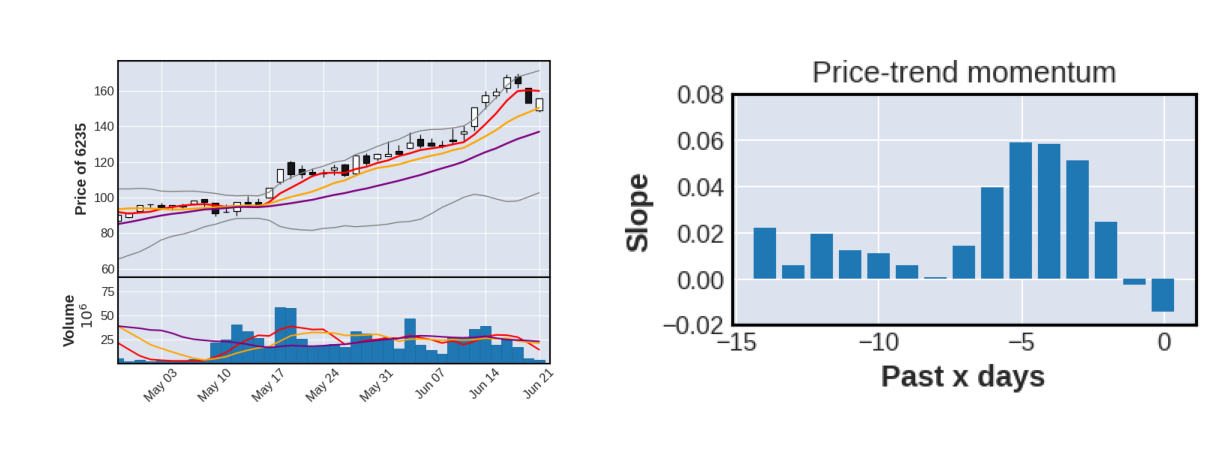

6187, ['萬潤', 516, 'meh', 'CoWoS產能將倍增 四檔最補']


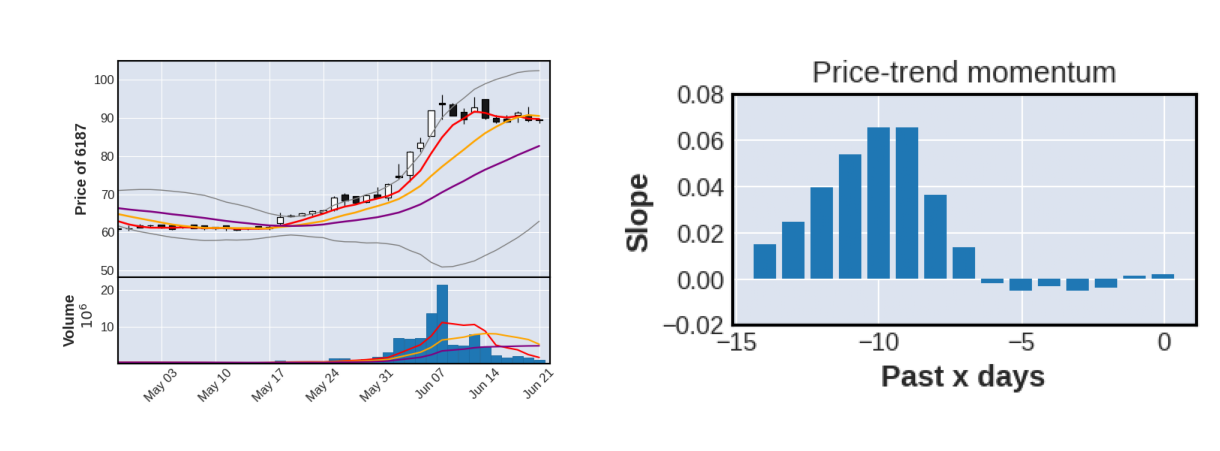

5465, ['富驊', 111, 'focus', '新品明年Q1出貨']


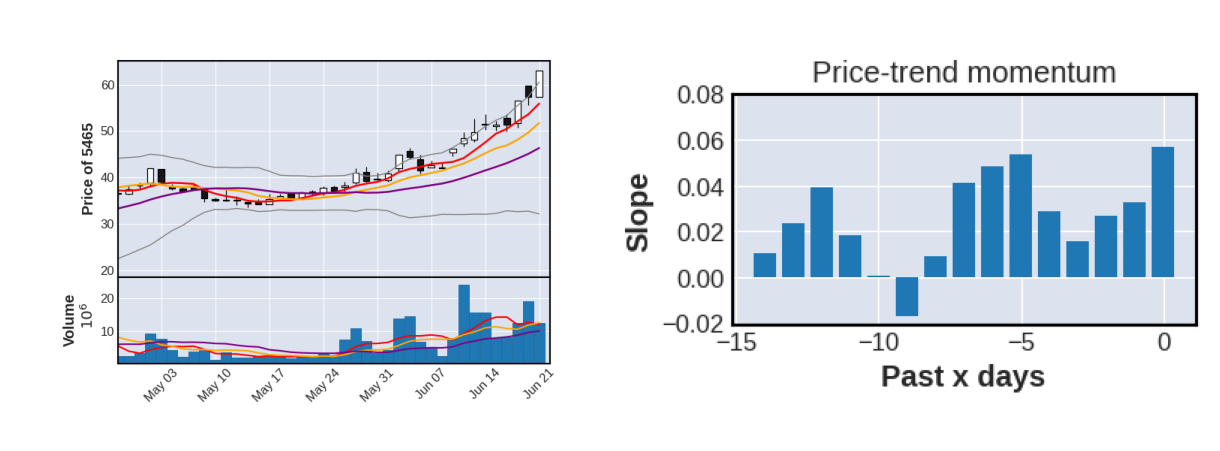

5258, ['虹堡', 36, 'focus', 'nan']


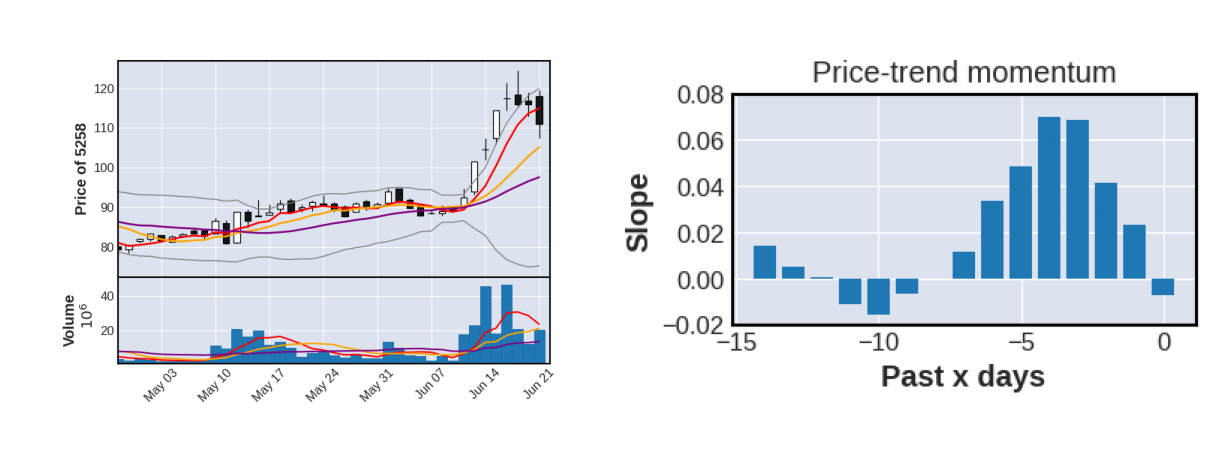

3711, ['日月光投控', 52, 'meh', 'CoWoS產能將倍增 四檔最補']


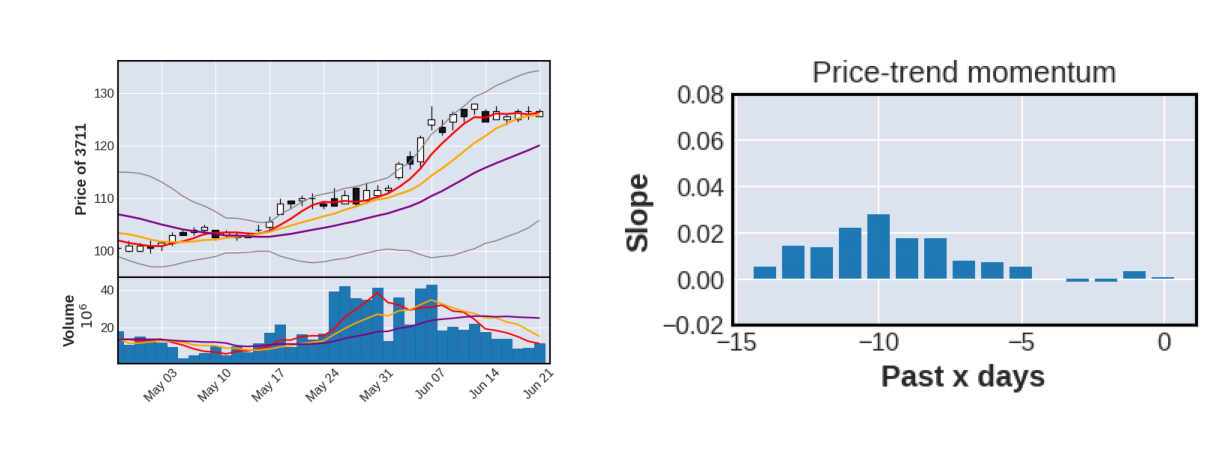

In [24]:
# For demo purpuse, only show 5
display_analysis(list(focus_dict.keys())[:5], focus_dict, detail_dict)

# Start analysis

In [25]:
# The dictionary that will be used to store all the ranking info below
final_ranking = dict()

## High potential: Extreme volume with high changes
- Stock that attracted a lot of investors in a short time. Have high potential.

In [26]:
# Change chosen_data to quickly change the analysed target stock lists
chosen_data = tw_dict

volume = {5: [],
          10: [],
          20: []}

for k in chosen_data.keys():
  # Limit price to below 400k
  if chosen_data[k].iloc[-1]["Close"] < 400 and chosen_data[k].iloc[-1]["InDayChg"] > 3:
    # Duplicates are acceptable in this section
    if chosen_data[k].iloc[-1]["relVMA20"] > 2:
      volume[20].append(k)
    if chosen_data[k].iloc[-1]["relVMA10"] > 2:
      volume[10].append(k)
    if chosen_data[k].iloc[-1]["relVMA5"] > 2:
      volume[5].append(k)

print(len(volume[5]), len(volume[10]), len(volume[20]))

19 28 31


In [27]:
final_ranking = add_ranking(list(set(volume[5] + volume[10])), final_ranking, "volume")

3089, ['億杰', 733]


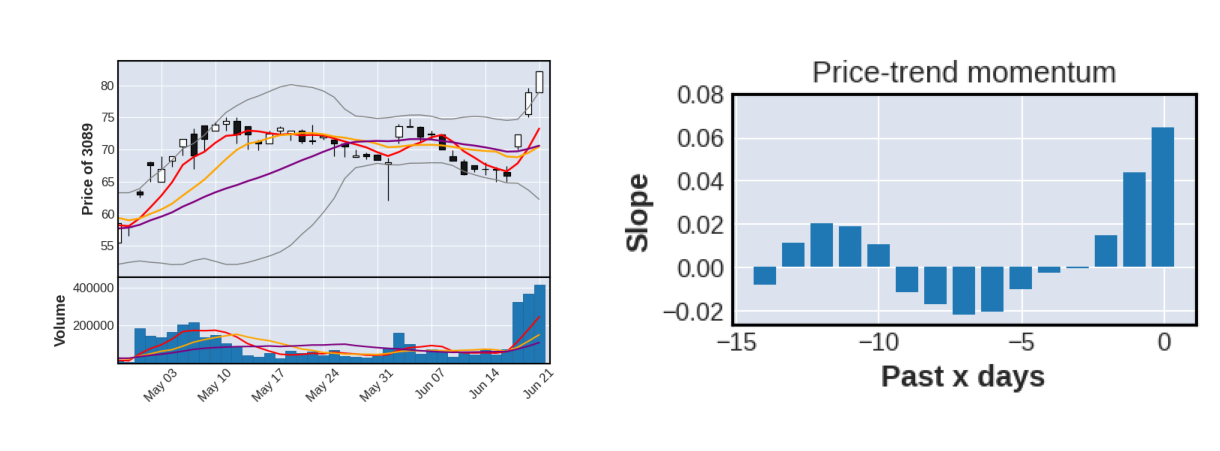

3673, ['TPK-KY', 100]


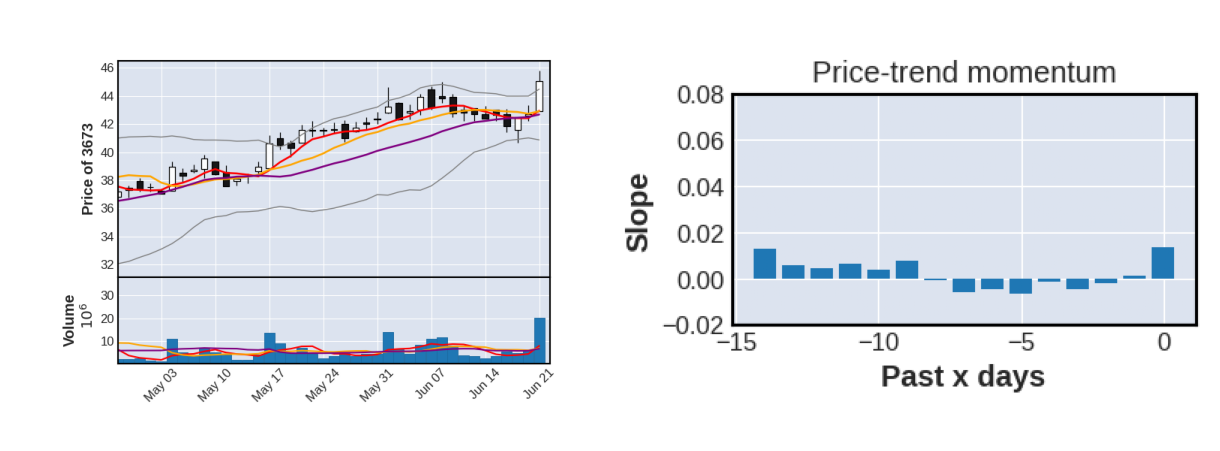

8358, ['金居', 34]


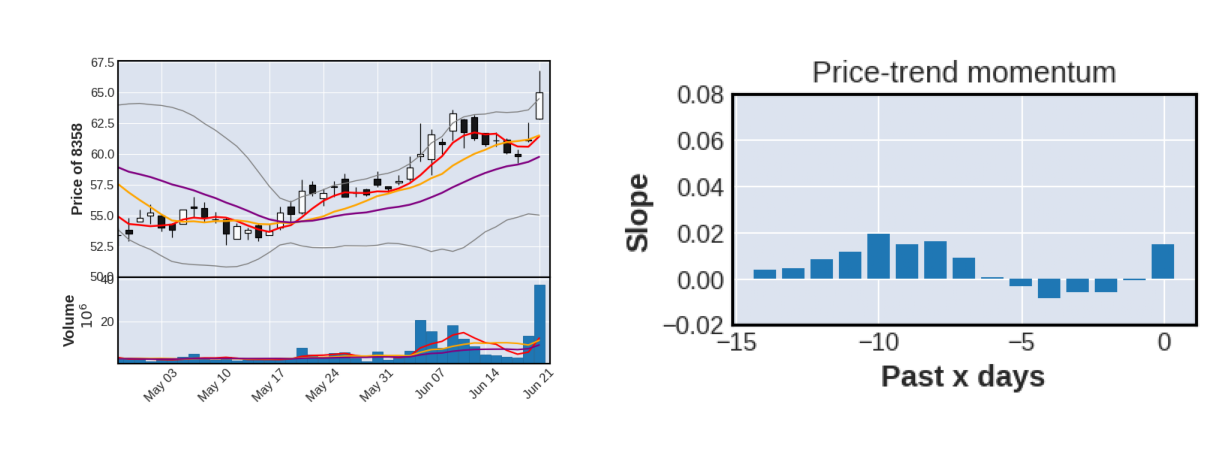

2073, ['雄順', 709]


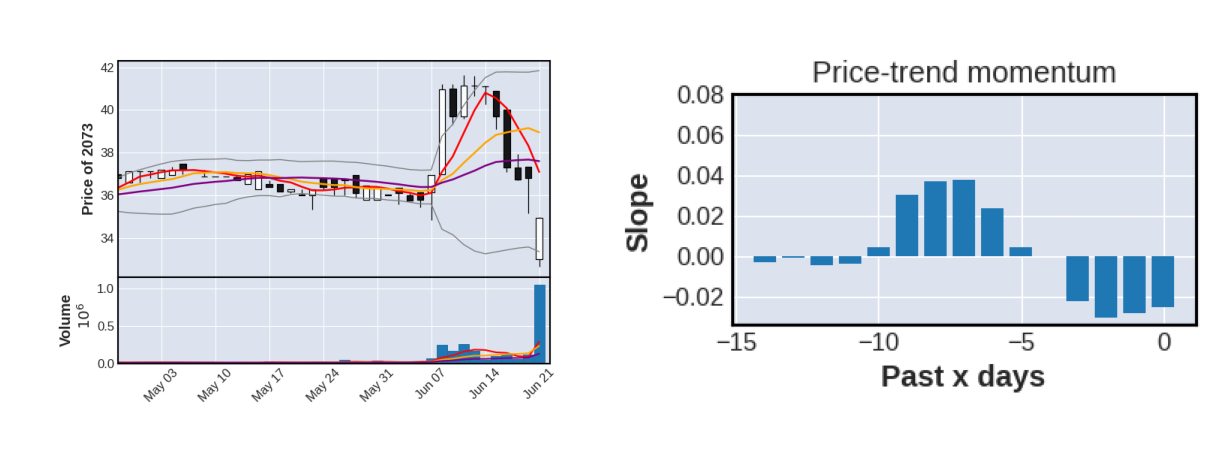

8147, ['正淩', 212]


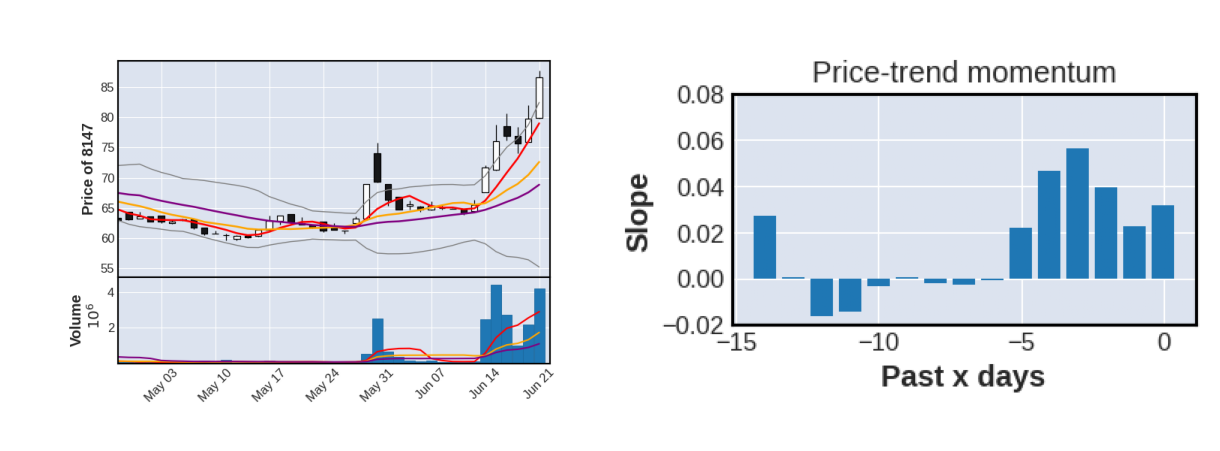

In [28]:
# For demo purpuse, only show 5
display_analysis(list(set(volume[5] + volume[10]))[:5], chosen_data, detail_dict)

## High potential: 10ma continuously growing
- Use this on full ticker lists to look for potential stocks (russell, s&p500...)
- Very strict constraint, stocks shown here have high potential


In [29]:
chosen_data = tw_dict

growth = {3: [],
          5: []}

for k in chosen_data.keys():
  diff = np.array(chosen_data[k][-19:]["MA10"]) - np.array(chosen_data[k][-20:-1]["MA10"])

  # Limit price to below 400k
  if chosen_data[k].iloc[-1]["Close"] < 400:
    if not np.any(diff < 0):
      # Save in order so there won't be duplicates
      if (diff[-5:] == sorted(diff[-5:])).all():
        growth[5].append(k)
      elif (diff[-3:] == sorted(diff[-3:])).all():
        growth[3].append(k)

print(len(growth[3]), len(growth[5]))

27 7


In [30]:
final_ranking = add_ranking(growth[3] + growth[5], final_ranking, "10ma up")

3665, ['貿聯-KY', 13]


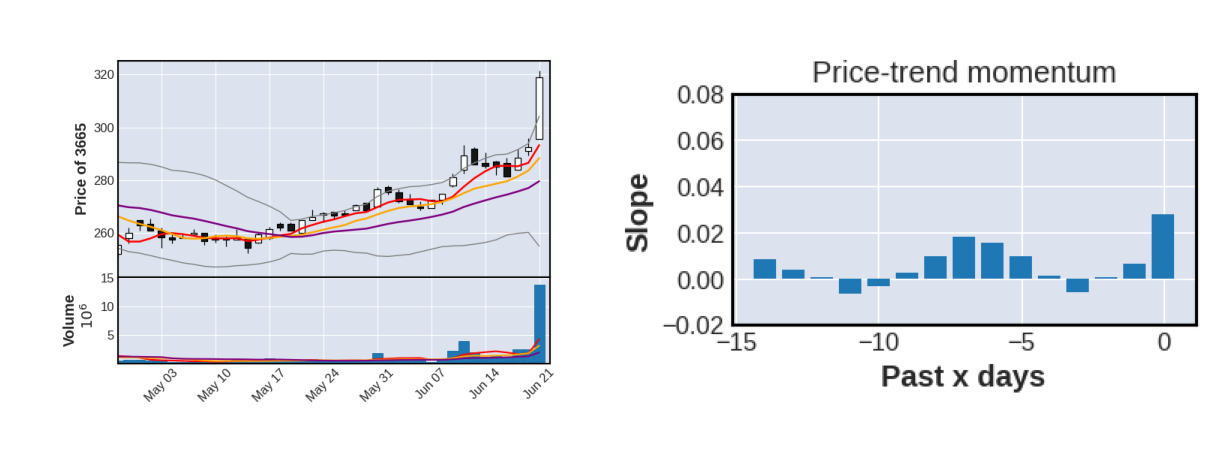

2722, ['夏都', 60]


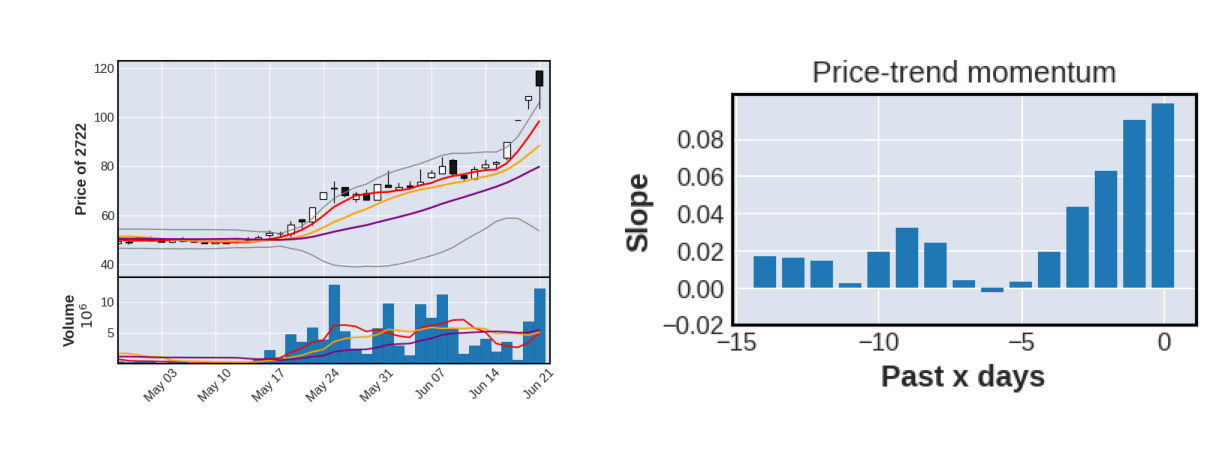

6203, ['海韻電', 72]


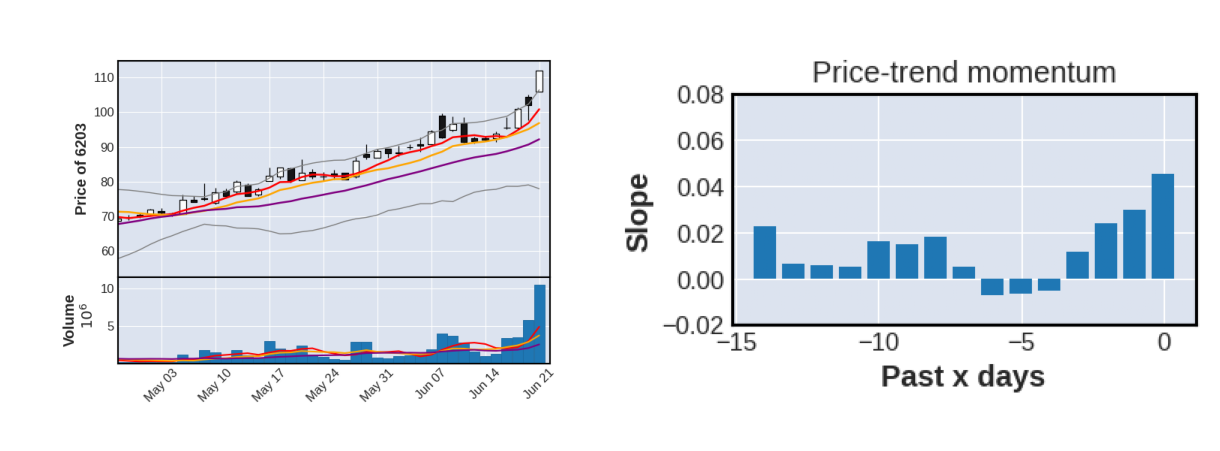

2405, ['輔信', 214]


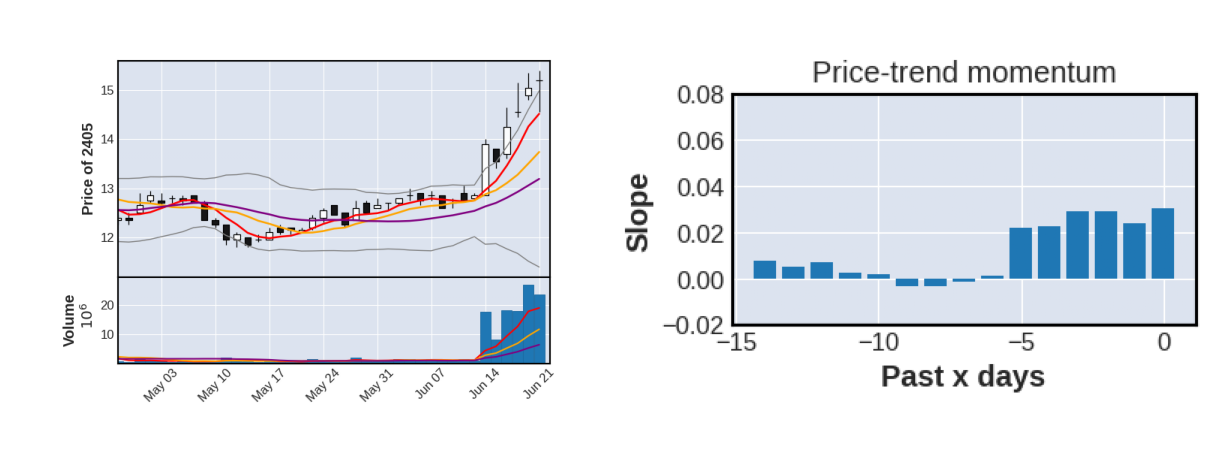

4563, ['百德', 861]


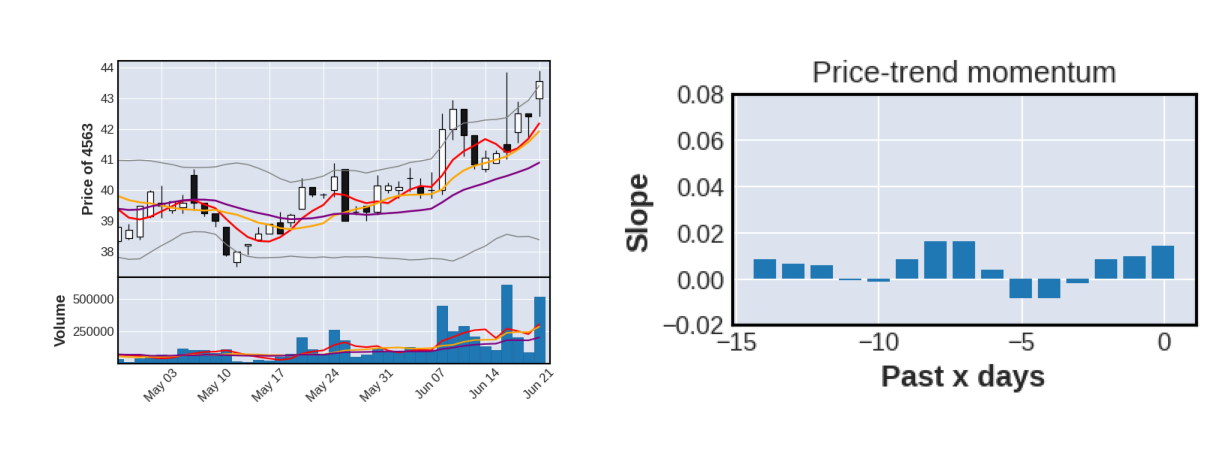

In [31]:
# For demo purpuse, only show 5
display_analysis(growth[5][:5], chosen_data, detail_dict)

## High potential: Slope continuously growing
- Depends on the given slope. A slope of 0.02 is quite a strict requirement.


In [32]:
# Change chosen_data to quickly change the analysed target stock lists
chosen_data = tw_dict

slope = {3: [],
         5: [],
         10: [],
         15: []}

for k in chosen_data.keys():
  slp = np.where(chosen_data[k][-20:]["slope"] > 0.02, 1, 0)

  # Limit price to below 400k
  if chosen_data[k].iloc[-1]["Close"] < 400:
    # Save in order so there won't be duplicates
    if sum(slp[-15:]) == 15:
      slope[15].append(k)
    elif sum(slp[-10:]) == 10:
      slope[10].append(k)
    elif sum(slp[-5:]) == 5:
      slope[5].append(k)
    elif sum(slp[-3:]) == 3:
      slope[3].append(k)

print(len(slope[3]), len(slope[5]), len(slope[10]), len(slope[15]))

26 11 0 0


In [33]:
final_ranking = add_ranking(slope[3] + slope[5] + slope[10] + slope[15], final_ranking, "slope")

2371, ['大同', 8, 'focus', 'nan']


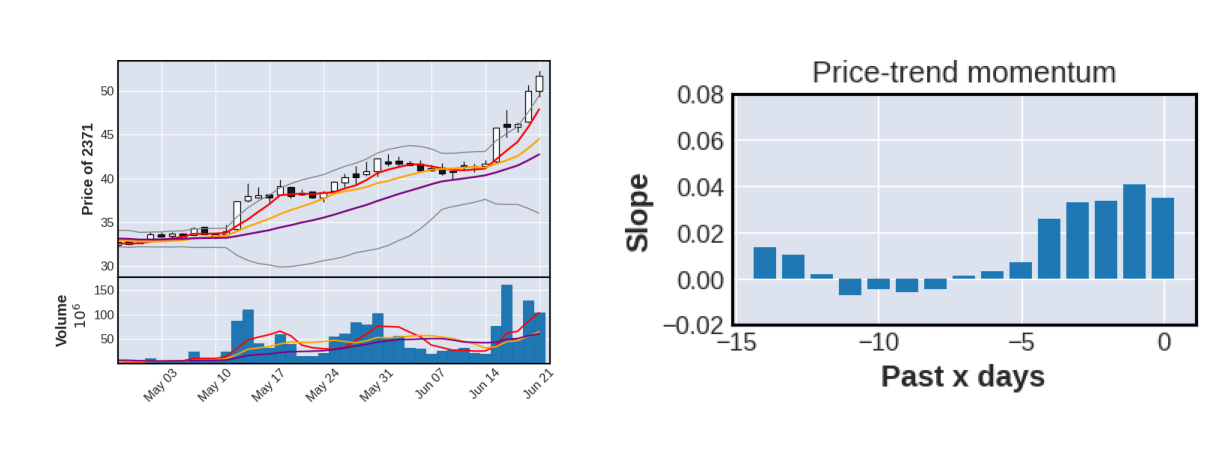

8210, ['勤誠', 30]


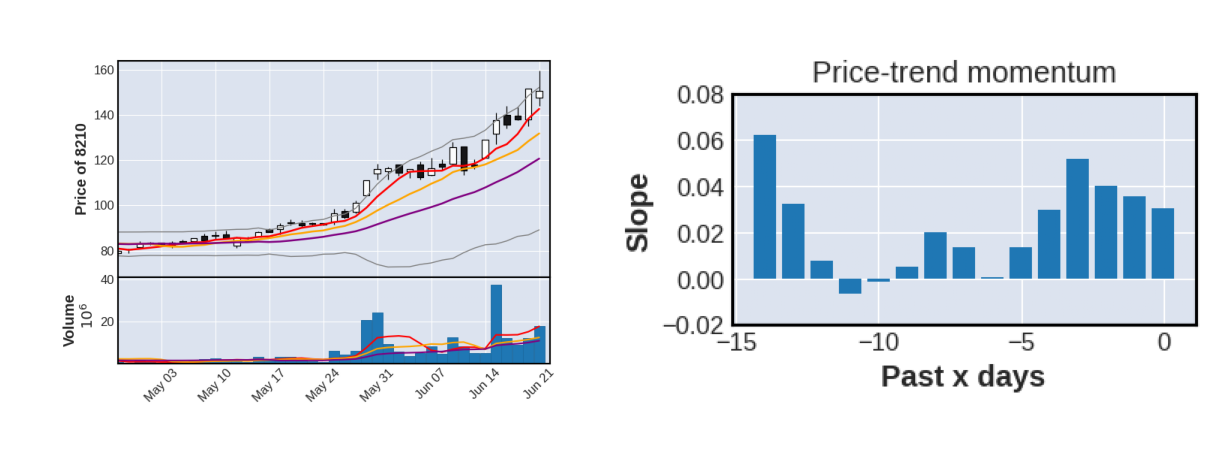

6120, ['達運', 99]


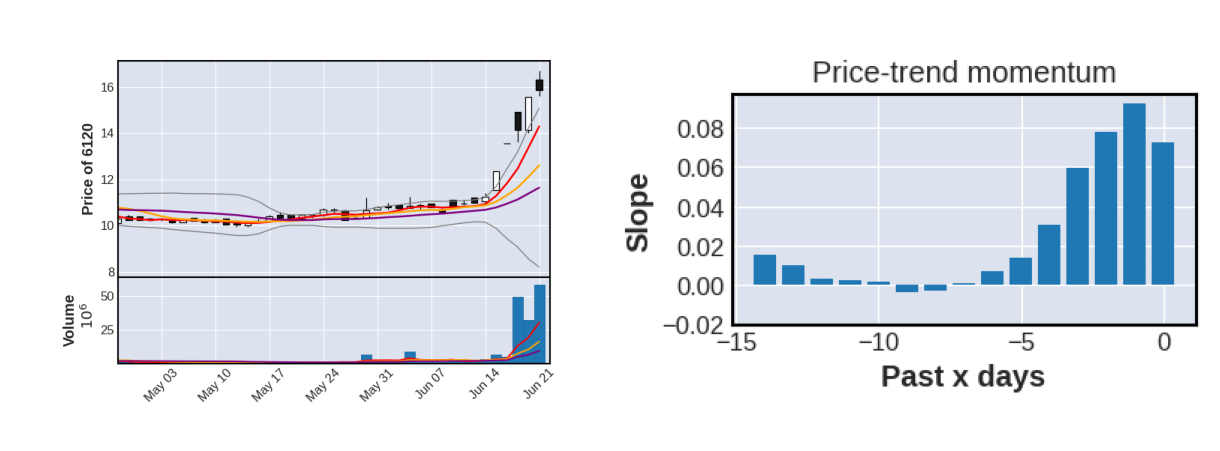

8147, ['正淩', 212]


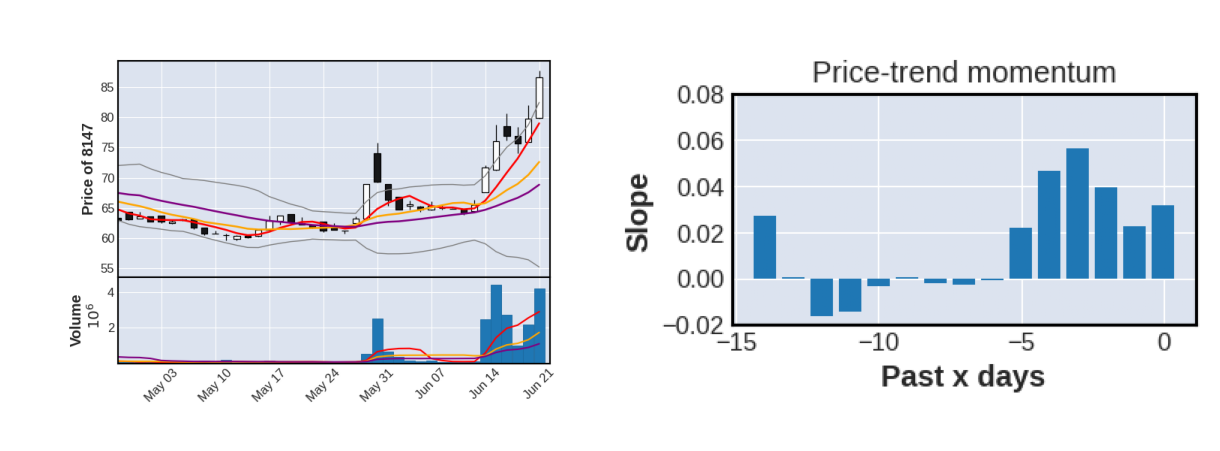

2405, ['輔信', 214]


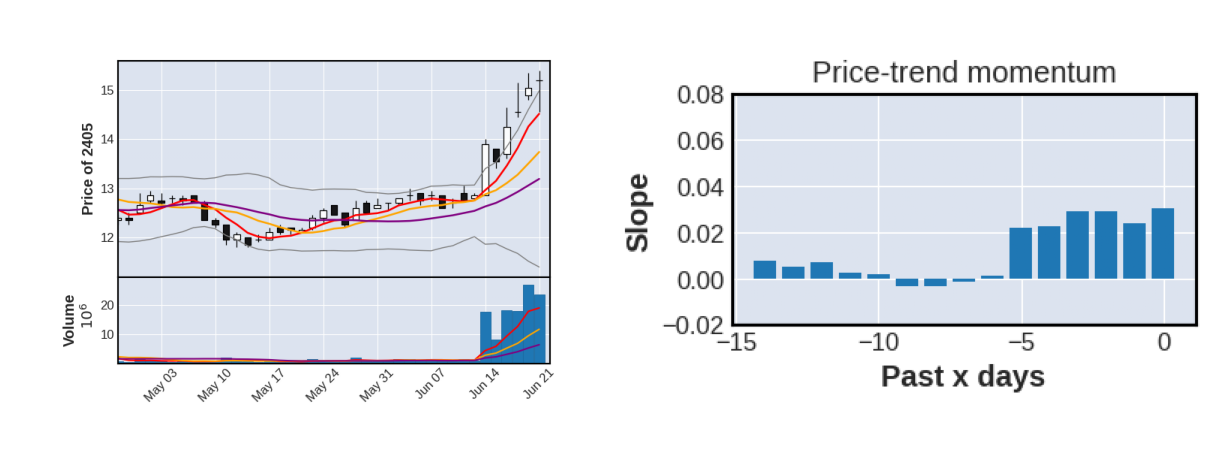

In [34]:
# For demo purpuse, only show 5
display_analysis(slope[5][:5], chosen_data, detail_dict)

## Mid potential: Close price > 5ma over certain days
- Use this on full ticker lists to look for potential stocks (russell, s&p500...)
- Not a strict constraint, may show a lot of stock that needs further inspection

In [35]:
# Change chosen_data to quickly change the analysed target stock lists
chosen_data = tw_dict

ma_5 = {5: [],
        10: [],
        15: []}

for k in chosen_data.keys():
  momentum = np.where(chosen_data[k][-20:]["Close"] > chosen_data[k][-20:]["MA5"], 1, 0)

  # Limit price to below 400k
  if chosen_data[k].iloc[-1]["Close"] < 400:
    # Save in order so there won't be duplicates
    if sum(momentum[-15:]) == 15:
      ma_5[15].append(k)
    elif sum(momentum[-10:]) == 10:
      ma_5[10].append(k)
    elif sum(momentum[-5:]) == 5:
      ma_5[5].append(k)

print(len(ma_5[5]), len(ma_5[10]), len(ma_5[15]))

130 11 11


In [36]:
final_ranking = add_ranking(ma_5[5] + ma_5[10] + ma_5[15], final_ranking, ">5ma")

3217, ['優群', 83]


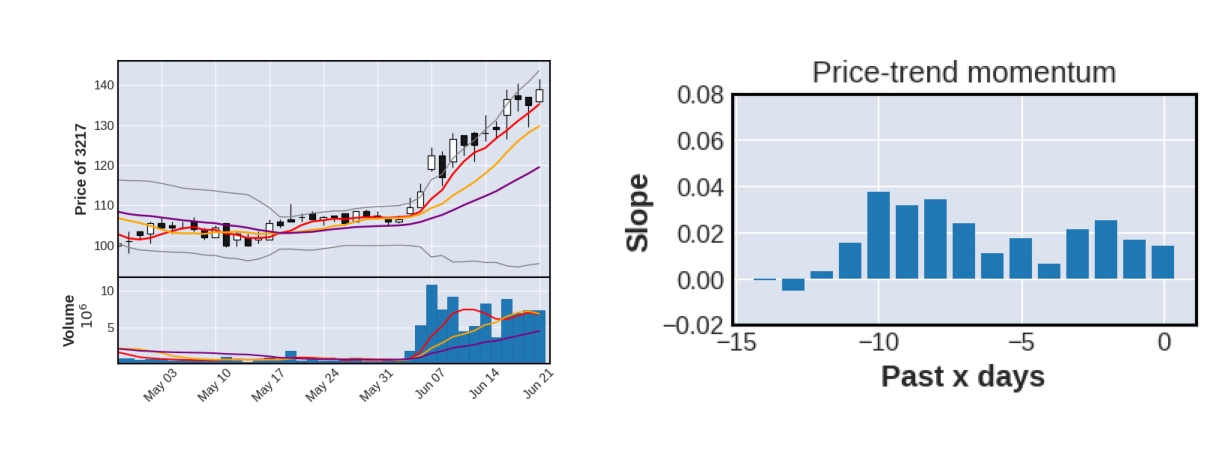

4967, ['十銓', 141]


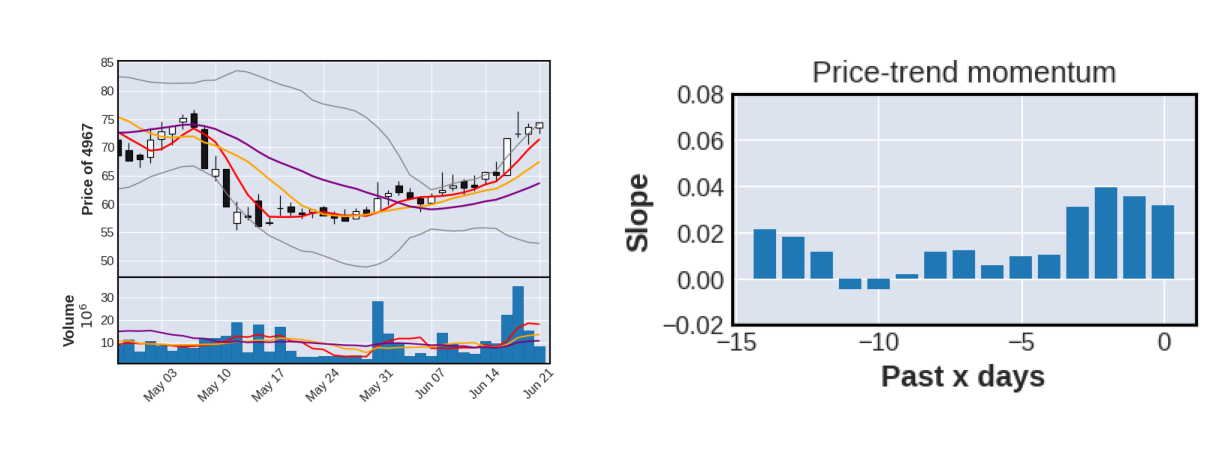

5426, ['振發', 275]


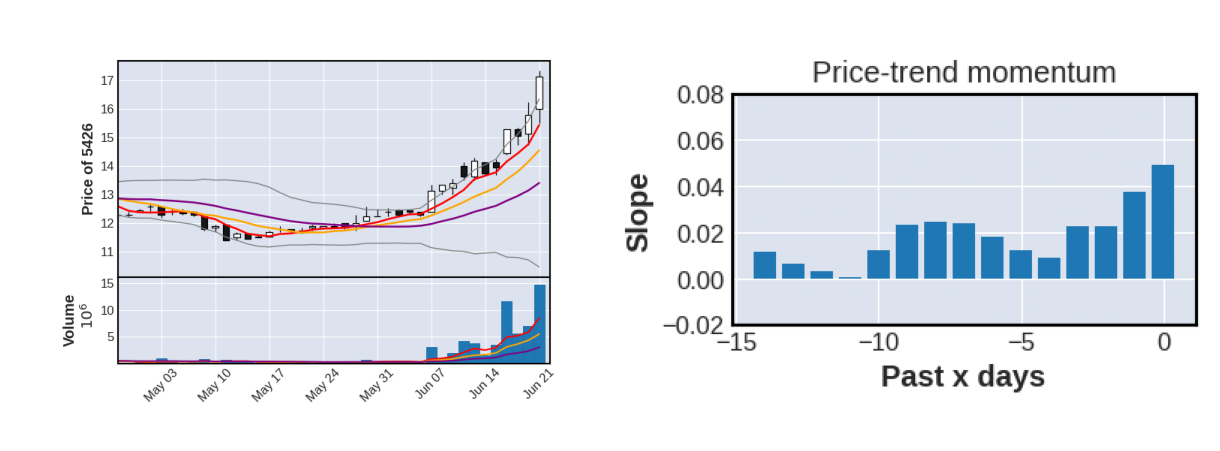

3498, ['陽程', 479]


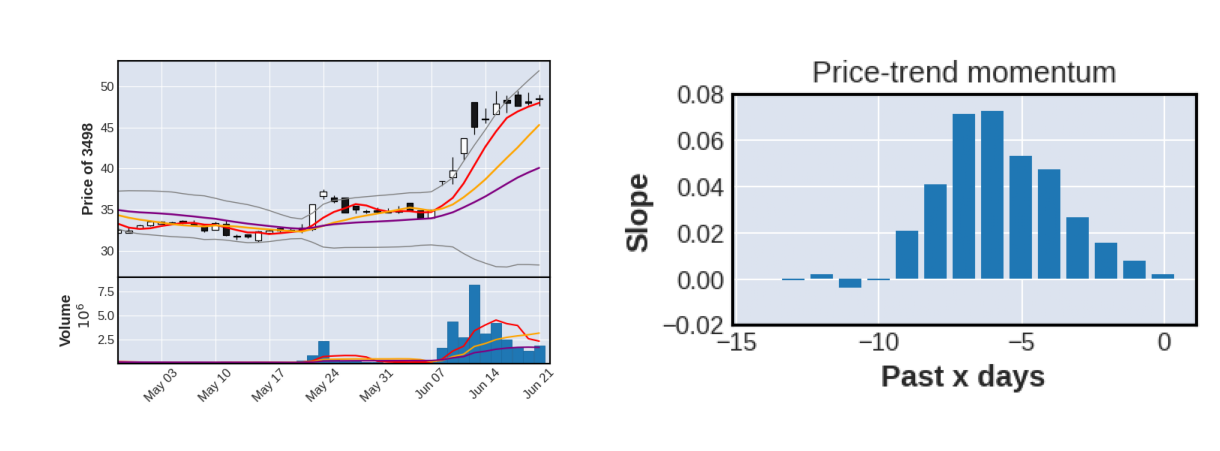

1786, ['科妍', 641]


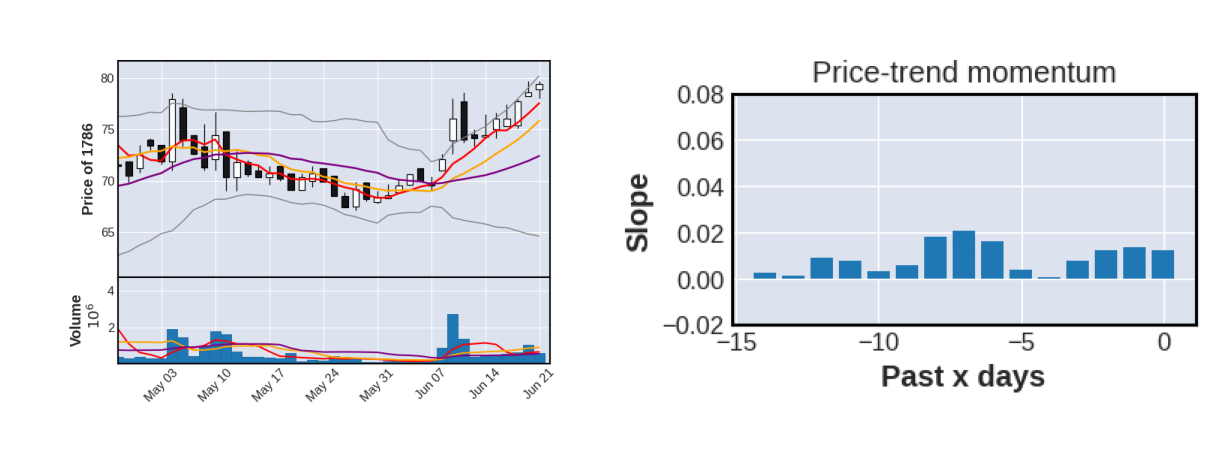

In [38]:
# For demo purpuse, only show 5
display_analysis((ma_5[10] + ma_5[15])[:5], chosen_data, detail_dict)

## Mid potential: 5ma > 10ma > 20ma over certain days
- A typical bullish trend

In [39]:
# Change chosen_data to quickly change the analysed target stock lists
chosen_data = tw_dict

ma_all = {5: [],
          10: [],
          15: []}

for k in chosen_data.keys():
  momentum = np.where(chosen_data[k][-20:]["MA5"] > chosen_data[k][-20:]["MA10"], 1, 0)
  momentum = np.where(chosen_data[k][-20:]["MA10"] > chosen_data[k][-20:]["MA20"], momentum, 0)

  # Limit price to below 400k
  if chosen_data[k].iloc[-1]["Close"] < 400:
    # Save in order so there won't be duplicates
    if sum(momentum[-15:]) == 15:
      ma_all[15].append(k)
    elif sum(momentum[-10:]) == 10:
      ma_all[10].append(k)
    elif sum(momentum[-5:]) == 5:
      ma_all[5].append(k)

print(len(ma_all[5]), len(ma_all[10]), len(ma_all[15]))

107 79 124


In [40]:
# there should be a lot tickers that matches, so there is not meaning plotting them all out

In [41]:
final_ranking = add_ranking(ma_all[5] + ma_all[10] + ma_all[15], final_ranking, "ma 5>10>20")

# Examine the final ranking

In [42]:
final_ranking = {key: val for key, val in final_ranking.items() if len(val) > 1}


In [43]:
worth_analysis = {}
for key, val in final_ranking.items():
  if len(val) >= 3:
    print(key, val, detail_dict[key])
    worth_analysis.update({key: [val, detail_dict[key]]})

8147 ['volume', 'slope', '>5ma', 'ma 5>10>20'] ['正淩', 212]
6219 ['volume', '>5ma', 'ma 5>10>20'] ['富旺', 723]
3481 ['volume', 'slope', '>5ma'] ['群創', 15]
5426 ['volume', '10ma up', 'slope', '>5ma', 'ma 5>10>20'] ['振發', 275]
6203 ['volume', '10ma up', 'slope', '>5ma', 'ma 5>10>20'] ['海韻電', 72]
3665 ['volume', '10ma up', 'ma 5>10>20'] ['貿聯-KY', 13]
5484 ['volume', '>5ma', 'ma 5>10>20'] ['慧友', 881]
2340 ['volume', '10ma up', 'ma 5>10>20'] ['台亞', 80]
1471 ['volume', 'slope', '>5ma', 'ma 5>10>20'] ['首利', 276]
6125 ['10ma up', 'slope', '>5ma', 'ma 5>10>20'] ['廣運', 44]
5465 ['10ma up', 'slope', '>5ma', 'ma 5>10>20'] ['富驊', 111, 'focus', '新品明年Q1出貨']
3325 ['10ma up', 'slope', '>5ma', 'ma 5>10>20'] ['旭品', 163]
8936 ['10ma up', '>5ma', 'ma 5>10>20'] ['國統', 280]
2607 ['10ma up', '>5ma', 'ma 5>10>20'] ['榮運', 424]
6117 ['10ma up', '>5ma', 'ma 5>10>20'] ['迎廣', 755]
6221 ['10ma up', '>5ma', 'ma 5>10>20'] ['晉泰', 978]
2722 ['10ma up', 'slope', '>5ma', 'ma 5>10>20'] ['夏都', 60]
2405 ['10ma up', 'slope', '>

8147, [['volume', 'slope', '>5ma', 'ma 5>10>20'], ['正淩', 212]]


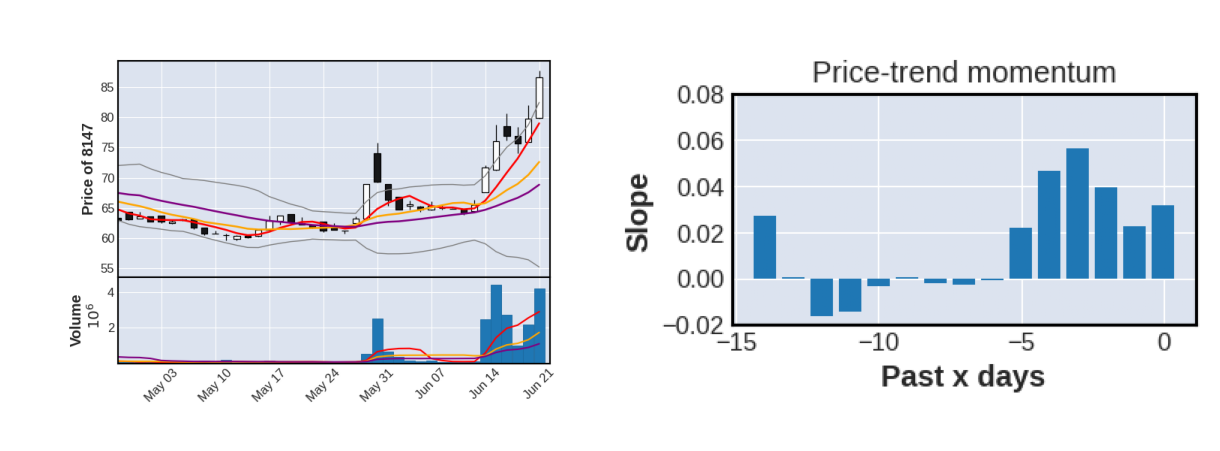

6219, [['volume', '>5ma', 'ma 5>10>20'], ['富旺', 723]]


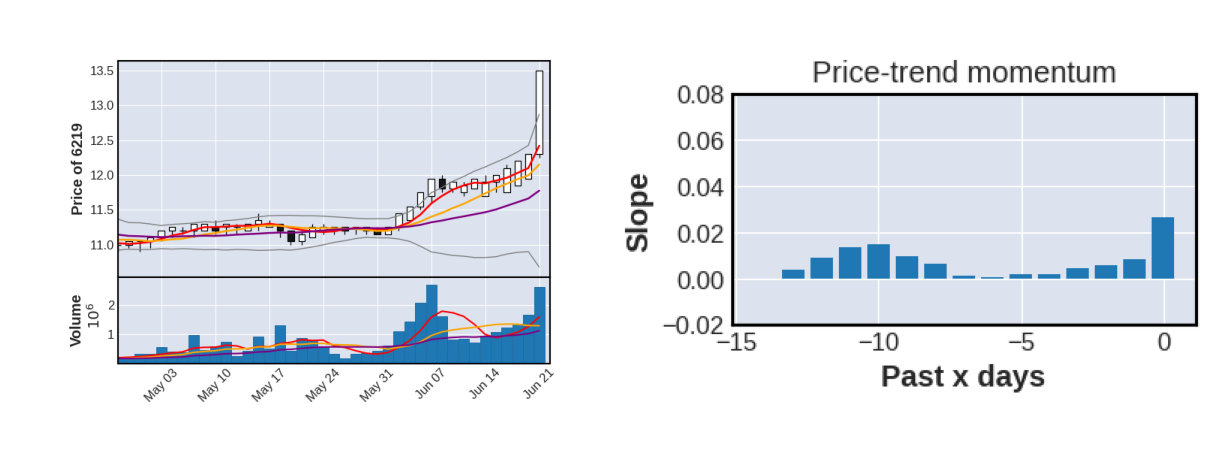

3481, [['volume', 'slope', '>5ma'], ['群創', 15]]


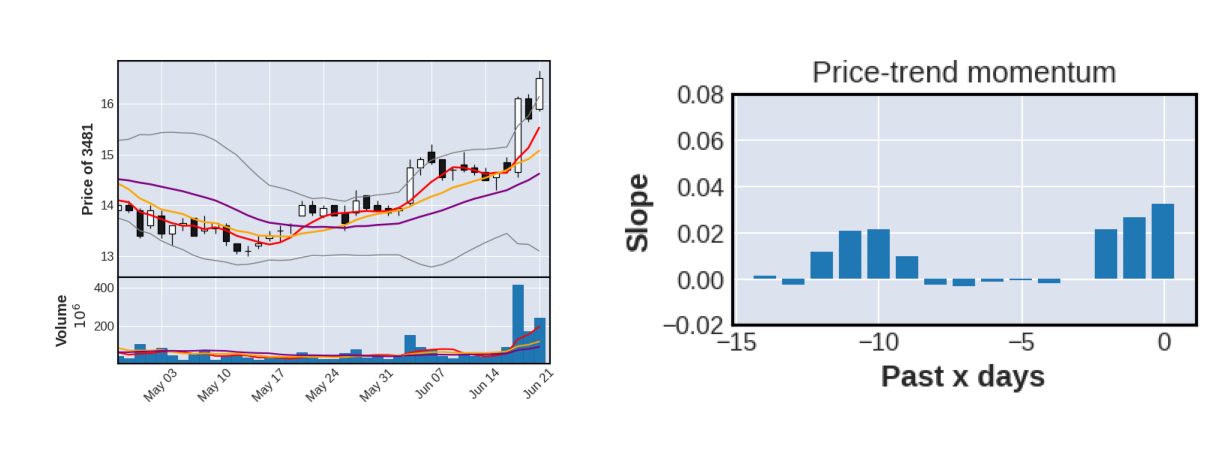

5426, [['volume', '10ma up', 'slope', '>5ma', 'ma 5>10>20'], ['振發', 275]]


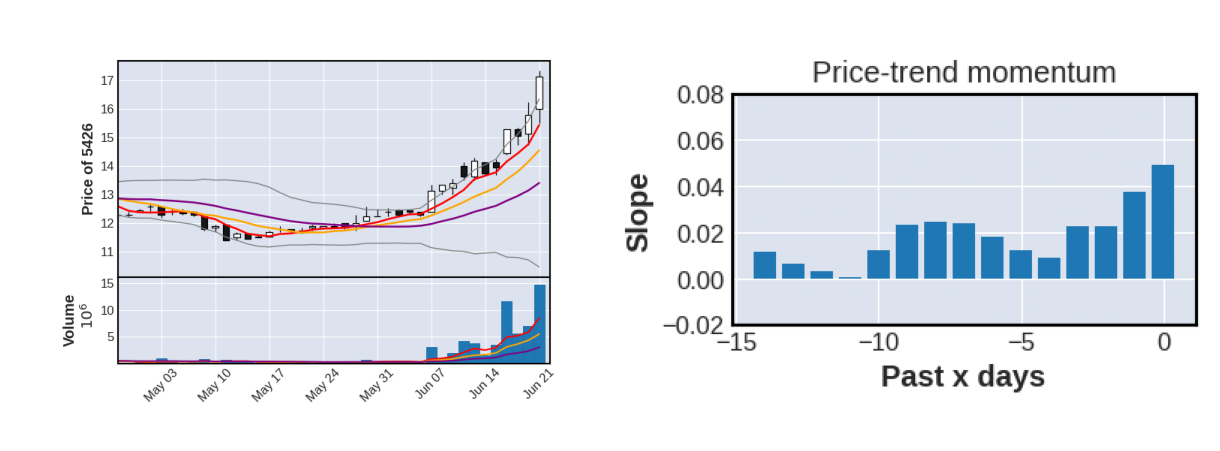

6203, [['volume', '10ma up', 'slope', '>5ma', 'ma 5>10>20'], ['海韻電', 72]]


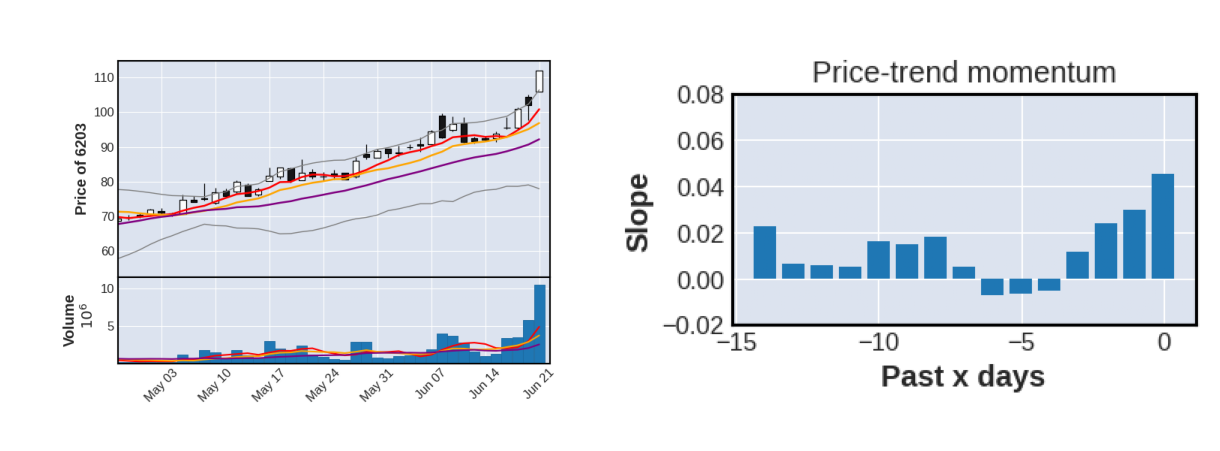

In [44]:
# For demo purpuse, only show 5
display_analysis(list(worth_analysis.keys())[:5], chosen_data, worth_analysis)

# Open websites for stock info

In [45]:
from IPython.display import Javascript, clear_output

def open_web(target):
  for t in target:
    url1 = "https://tw.stock.yahoo.com/quote/" + t + "/news"
    url2 = "https://www.cmoney.tw/forum/stock/" + t[:4]
    display(Javascript('window.open("{url}");'.format(url=url1)))
    display(Javascript('window.open("{url}");'.format(url=url2)))




In [46]:
# open_web(momentum_15 + momentum_5)


In [47]:
# Avoid auto-opening webpages every time opening this notebook
# clear_output()